In [1]:
using AbstractGPs # Abstract types and methods for Gaussian Processes
using GRUtils # Plotting in Julia
using KernelFunctions # Kernels for Gaussian processes
using LombScargle # Computing Lomb-Scargle periodogram, duh
using Optim # Optimization of functions
using PyCall # Package to call Python functions from the Julia language
using Statistics # Basic statistics functionality
using Stheno # Probabilistic programming with Gaussian processes
using Zygote # Automatic calculation of gradients

In [2]:
# Import the package
lightkurve = pyimport("lightkurve")

# Get the long cadence data of the 5th quarter 
data = lightkurve.search_lightcurve("KIC1430163", cadence="long", quarter=5).download(quality_bitmask="hardest")

# Unpack the data
const t = get(data, "time").value
const tₘ = t .- mean(t)
const f = get(data, "pdcsap_flux").value
const fσ = get(data, "pdcsap_flux_err").value;

In [3]:
# An auxiliary variable for the general shift of text output to the left
pad = 30

println(rpad("General info:", pad))
println(rpad("Size of the subset:", pad), size(t, 1))

const μ₀ = mean(f)
println(rpad("Mean of the flux: ", pad), μ₀)

const A₀ = var(f)
println(rpad("Variance of the flux: ", pad), A₀)

const σ²ₑ = var(fσ)
println(rpad("Variance of the errors: ", pad), σ²ₑ)

# Calculating the mean of the time differences between observations
Δt = []
for i in range(2, size(t, 1), step = 1)
    push!(Δt, t[i] - t[i-1])
end
Δμ = sum(Δt) / size(Δt, 1)

println(rpad("Mean of the time differences:", pad), Δμ)

General info:                 
Size of the subset:           3519
Mean of the flux:             2.125678e6
Variance of the flux:         209420.36
Variance of the errors:       0.002832904
Mean of the time differences: 0.026614859881868173


In [4]:
# Set the primary line color
linecolor = 0x425378;

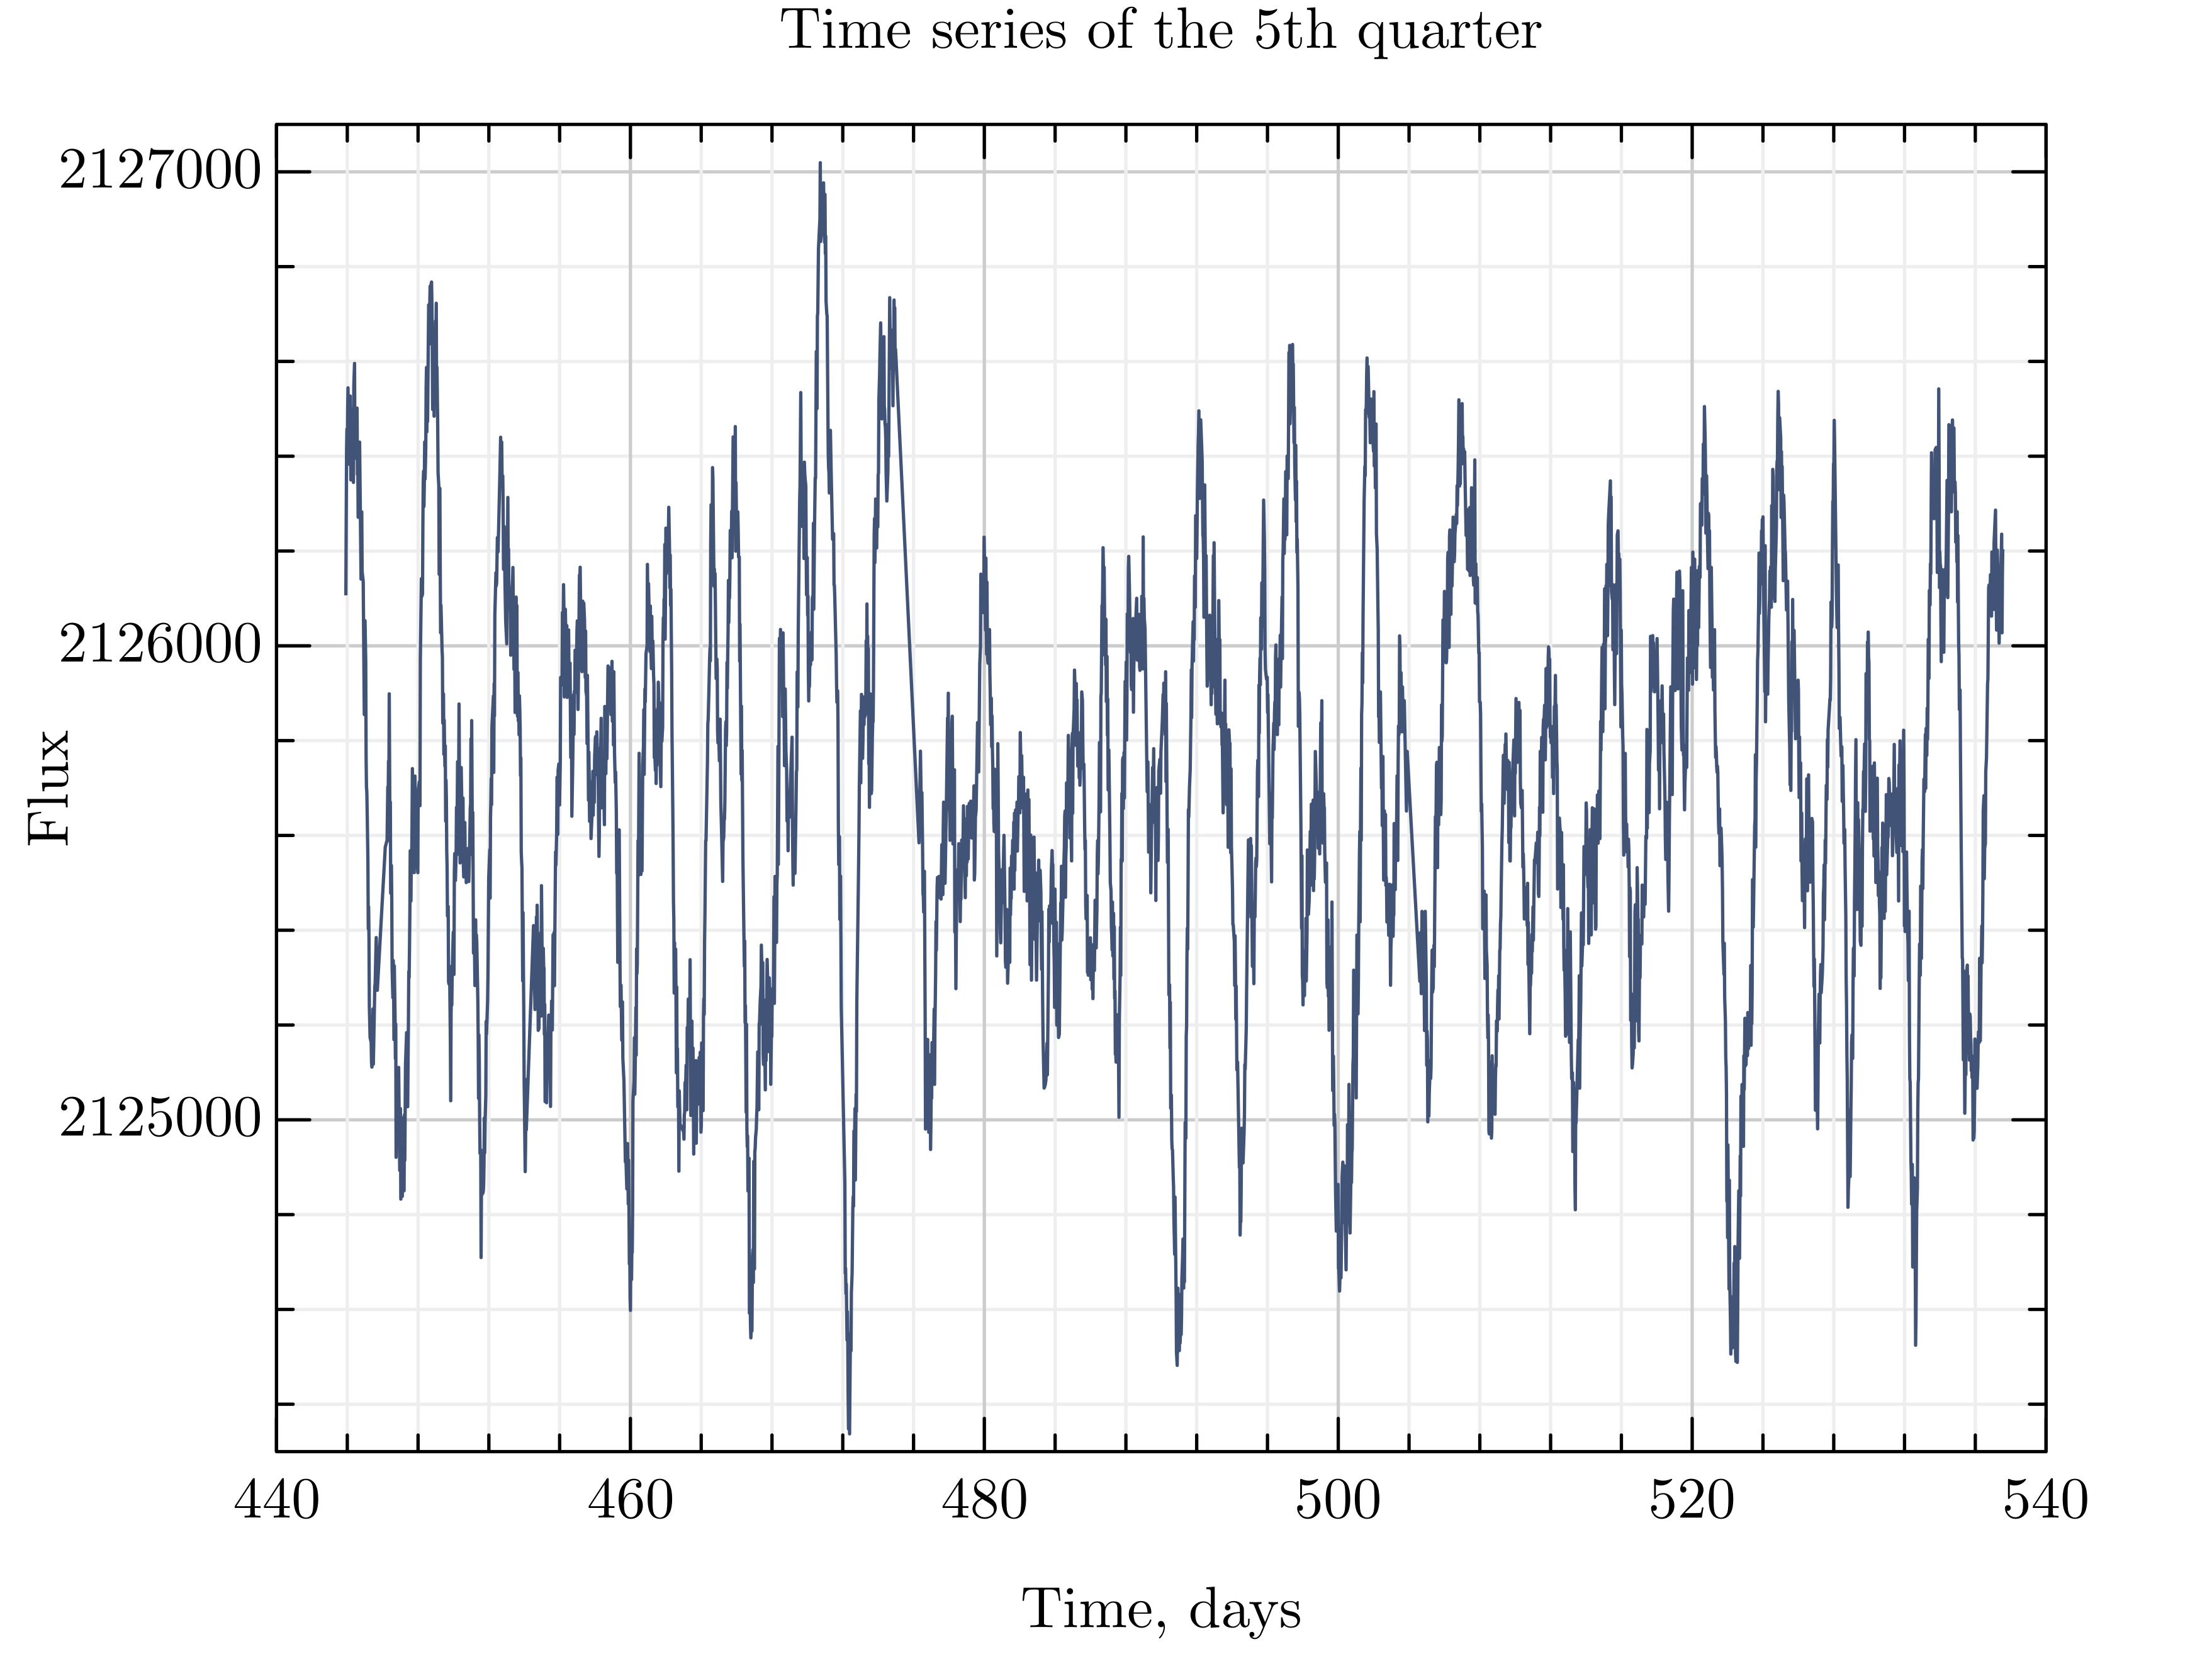

In [5]:
plot(t, f; linecolor)
xlabel("Time, days")
ylabel("Flux")
title("Time series of the 5th quarter")

Lomb–Scargle periodogram:
The peak is at 0.2222989453247285.
The relevant estimate of the period is 4.498446893390457.
At least 216 points are required to infer this period.


GKS: invalid workstation type (Base.RefValue{String}("Base.RefValue{String}(\"svg\")"))


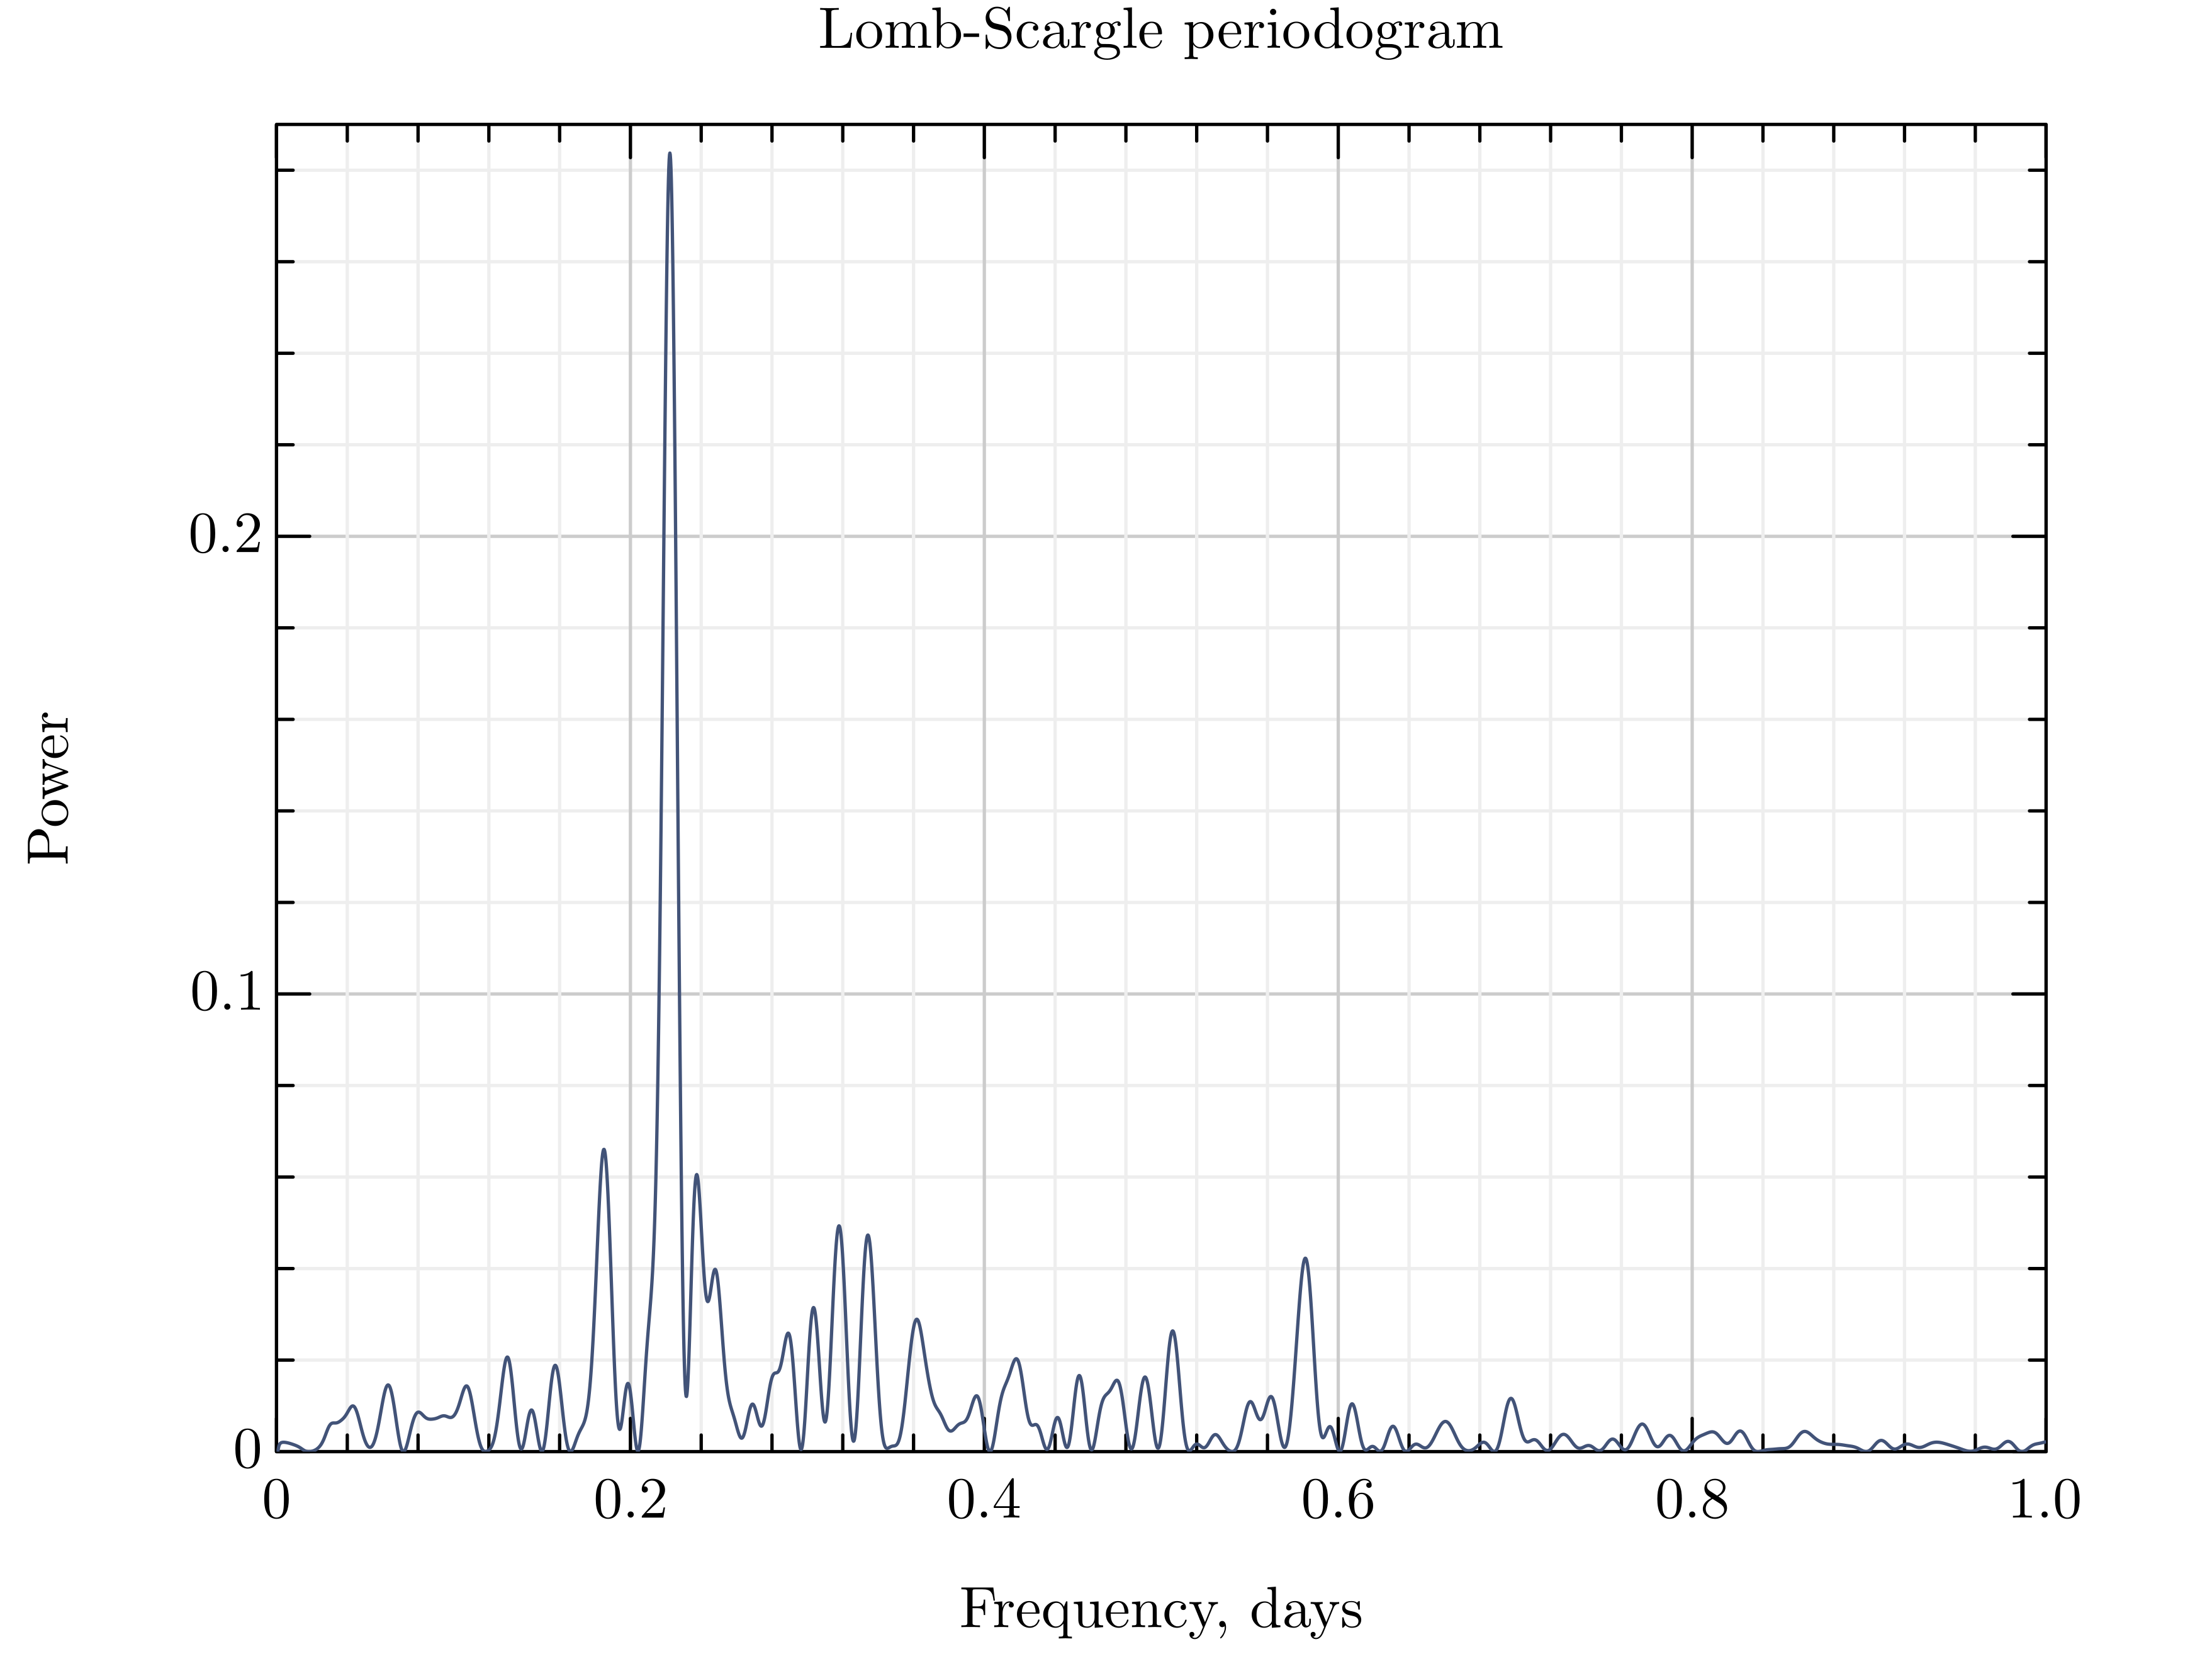

In [6]:
# Choose a set of frequencies
frequencies = range(1 / size(t, 1) + 0.0003, 1.0; length = 5000)

# Pre-plan the Lomb–Scargle periodogram
plan = LombScargle.plan(t, f, fσ; frequencies)

# Compute the Lomb–Scargle periodogram
p = lombscargle(plan)

# Get the frequency and the power vectors
ν, P = freqpower(p)

# Determine the peak
νₘ = findmaxfreq(p)[1]

# Determine the period at this peak
P₀ = 1 / νₘ

# Determine the minimal number of points required to infer this period
n = Int(ceil(P₀ * 24 * 60 / 30))

plot(ν, P; linecolor)

title("Lomb-Scargle periodogram")
xlabel("Frequency, days")
ylabel("Power")

println("""
Lomb–Scargle periodogram:
The peak is at $(νₘ).
The relevant estimate of the period is $(P₀).
At least $(n) points are required to infer this period.""")

gcf()

GKS: invalid workstation type (Base.RefValue{String}("Base.RefValue{String}(\"Base.RefValue{String}(\\\"Base.RefValue{String}(\\\\\\\"svg\\\\\\\")\\\")\")"))


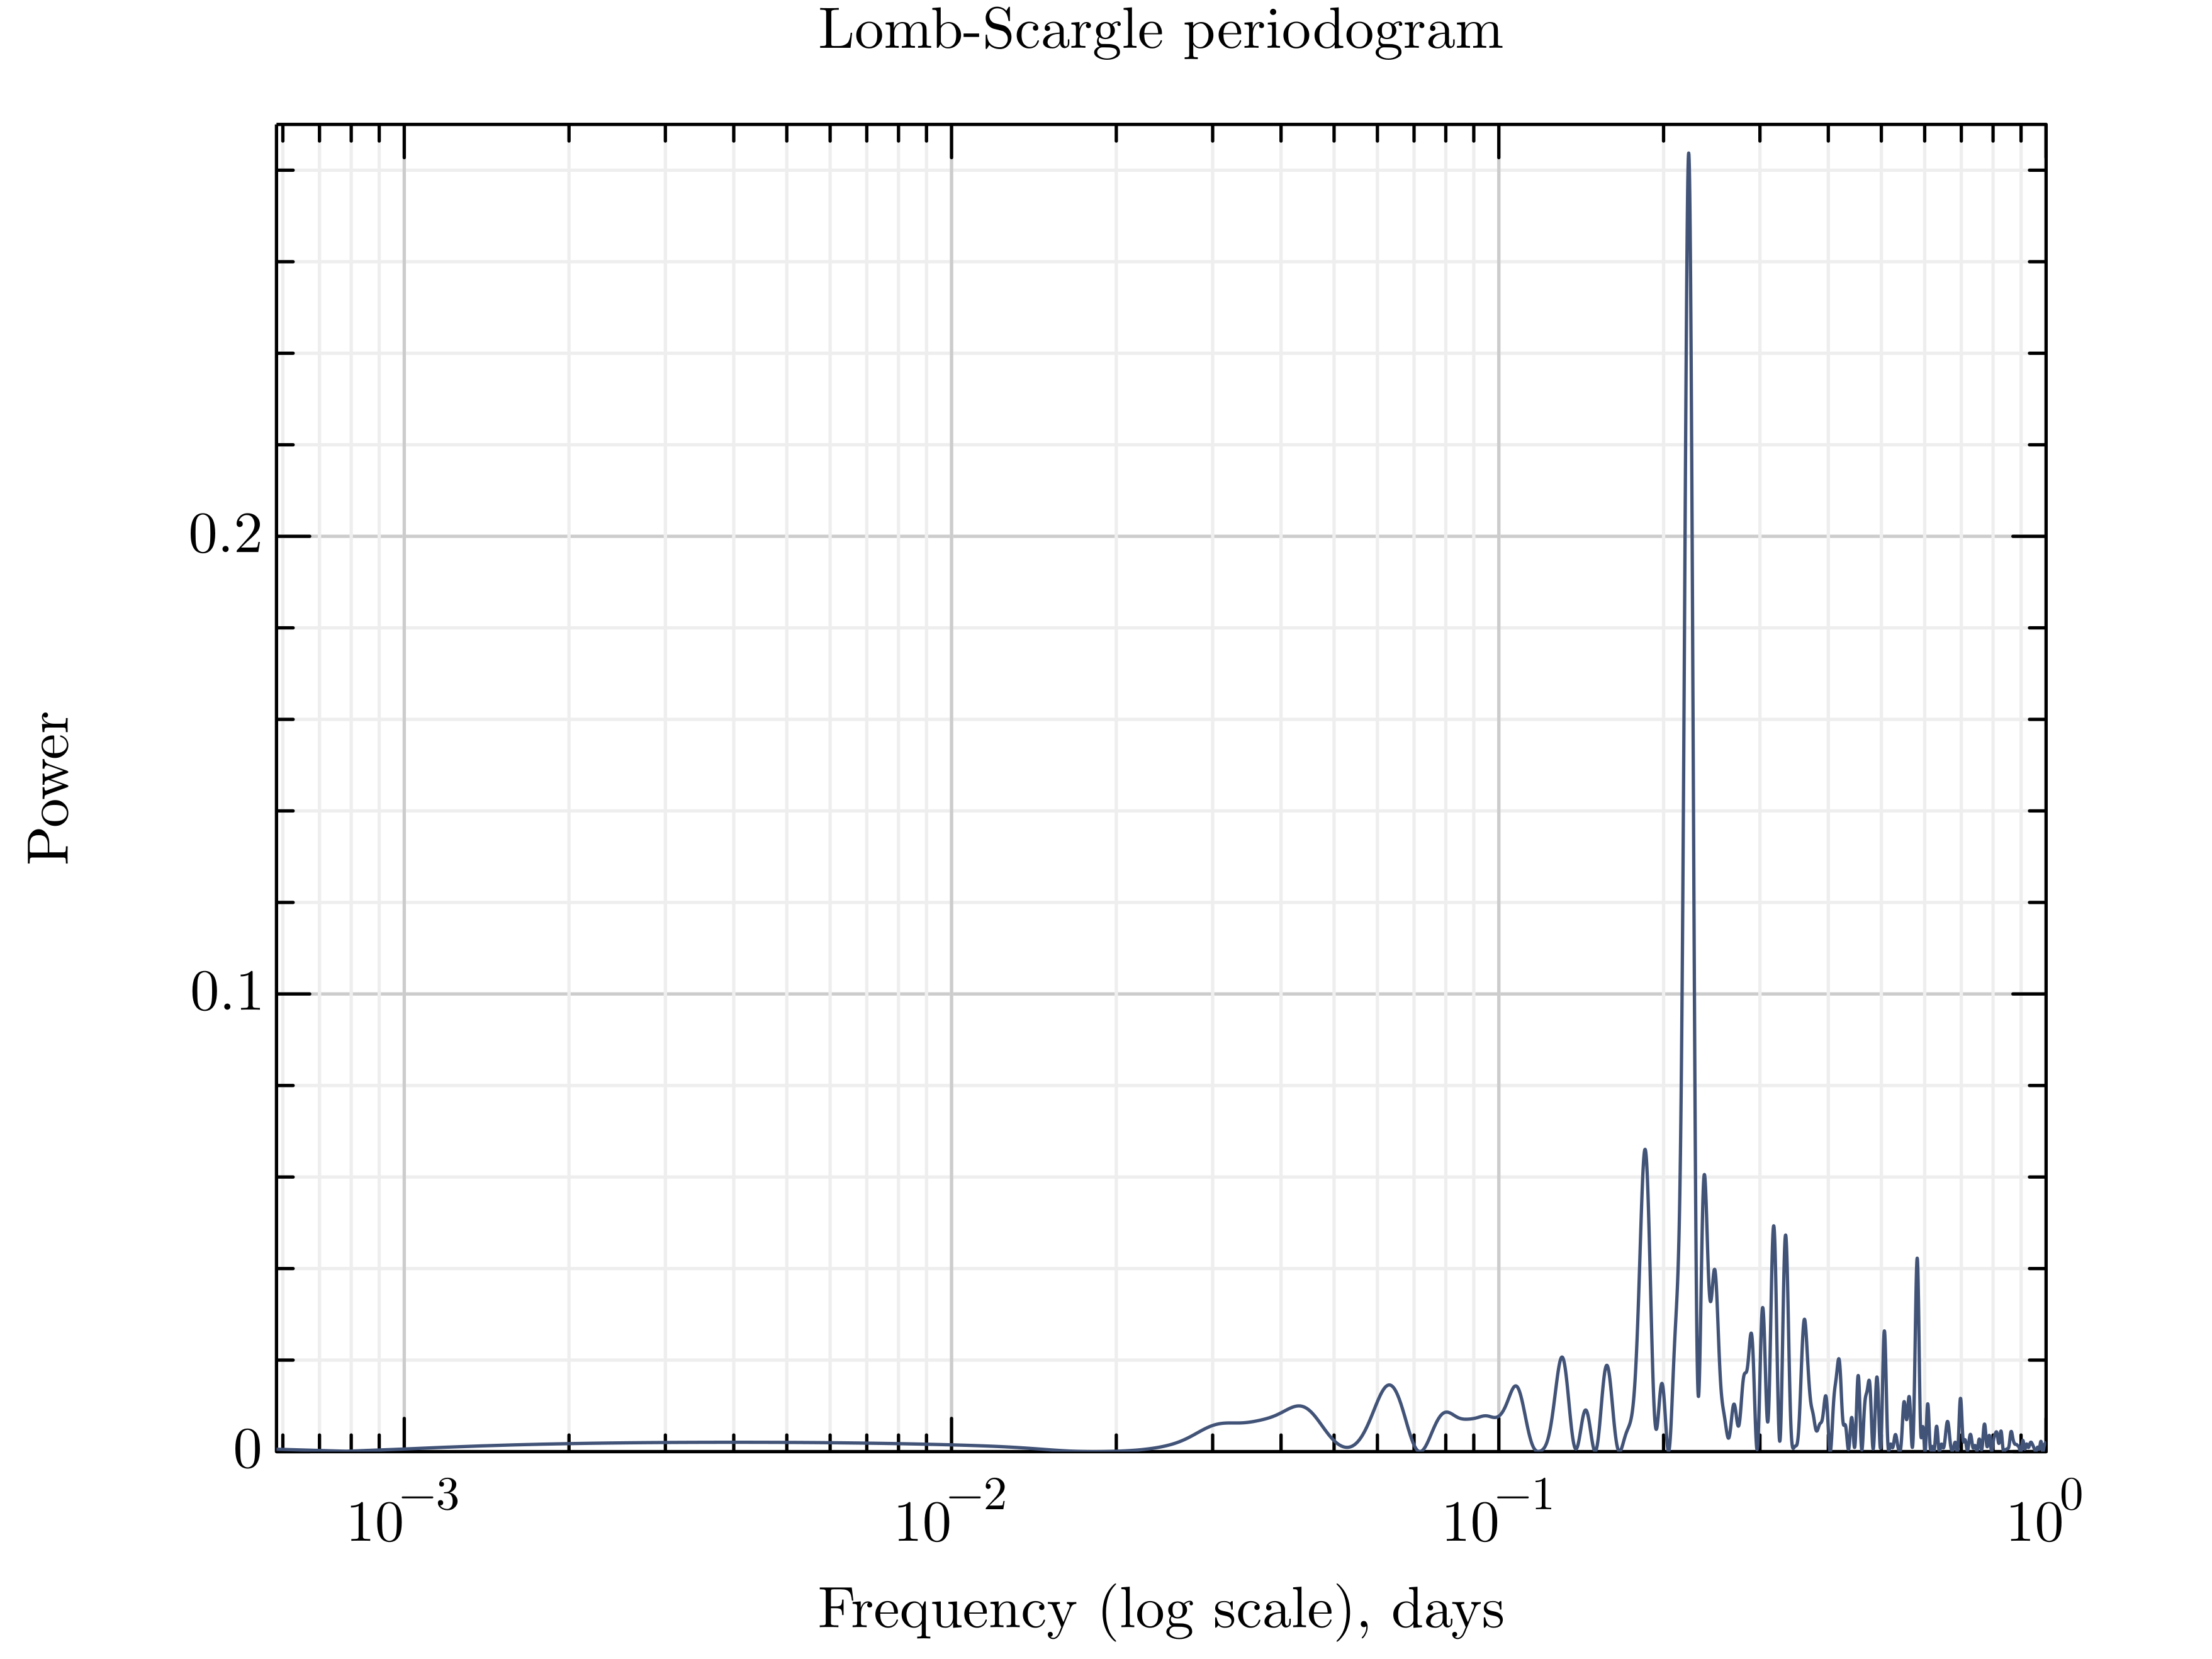

In [7]:
plot(ν, P; linecolor)

title("Lomb-Scargle periodogram")
xlabel("Frequency (log scale), days")
ylabel("Power")
xlog(true)

In [8]:
tₛ = t[1:n*2]
fₛ = f[1:n*2]

Aₛ = var(fₛ)
μₛ = mean(fₛ);

GKS: invalid workstation type (Base.RefValue{String}("Base.RefValue{String}(\"Base.RefValue{String}(\\\"Base.RefValue{String}(\\\\\\\"Base.RefValue{String}(\\\\\\\\\\\\\\\"Base.RefValue{String}(\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\"svg\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\")\\\\\\\\\\\\\\\")\\\\\\\")\\\")\")"))


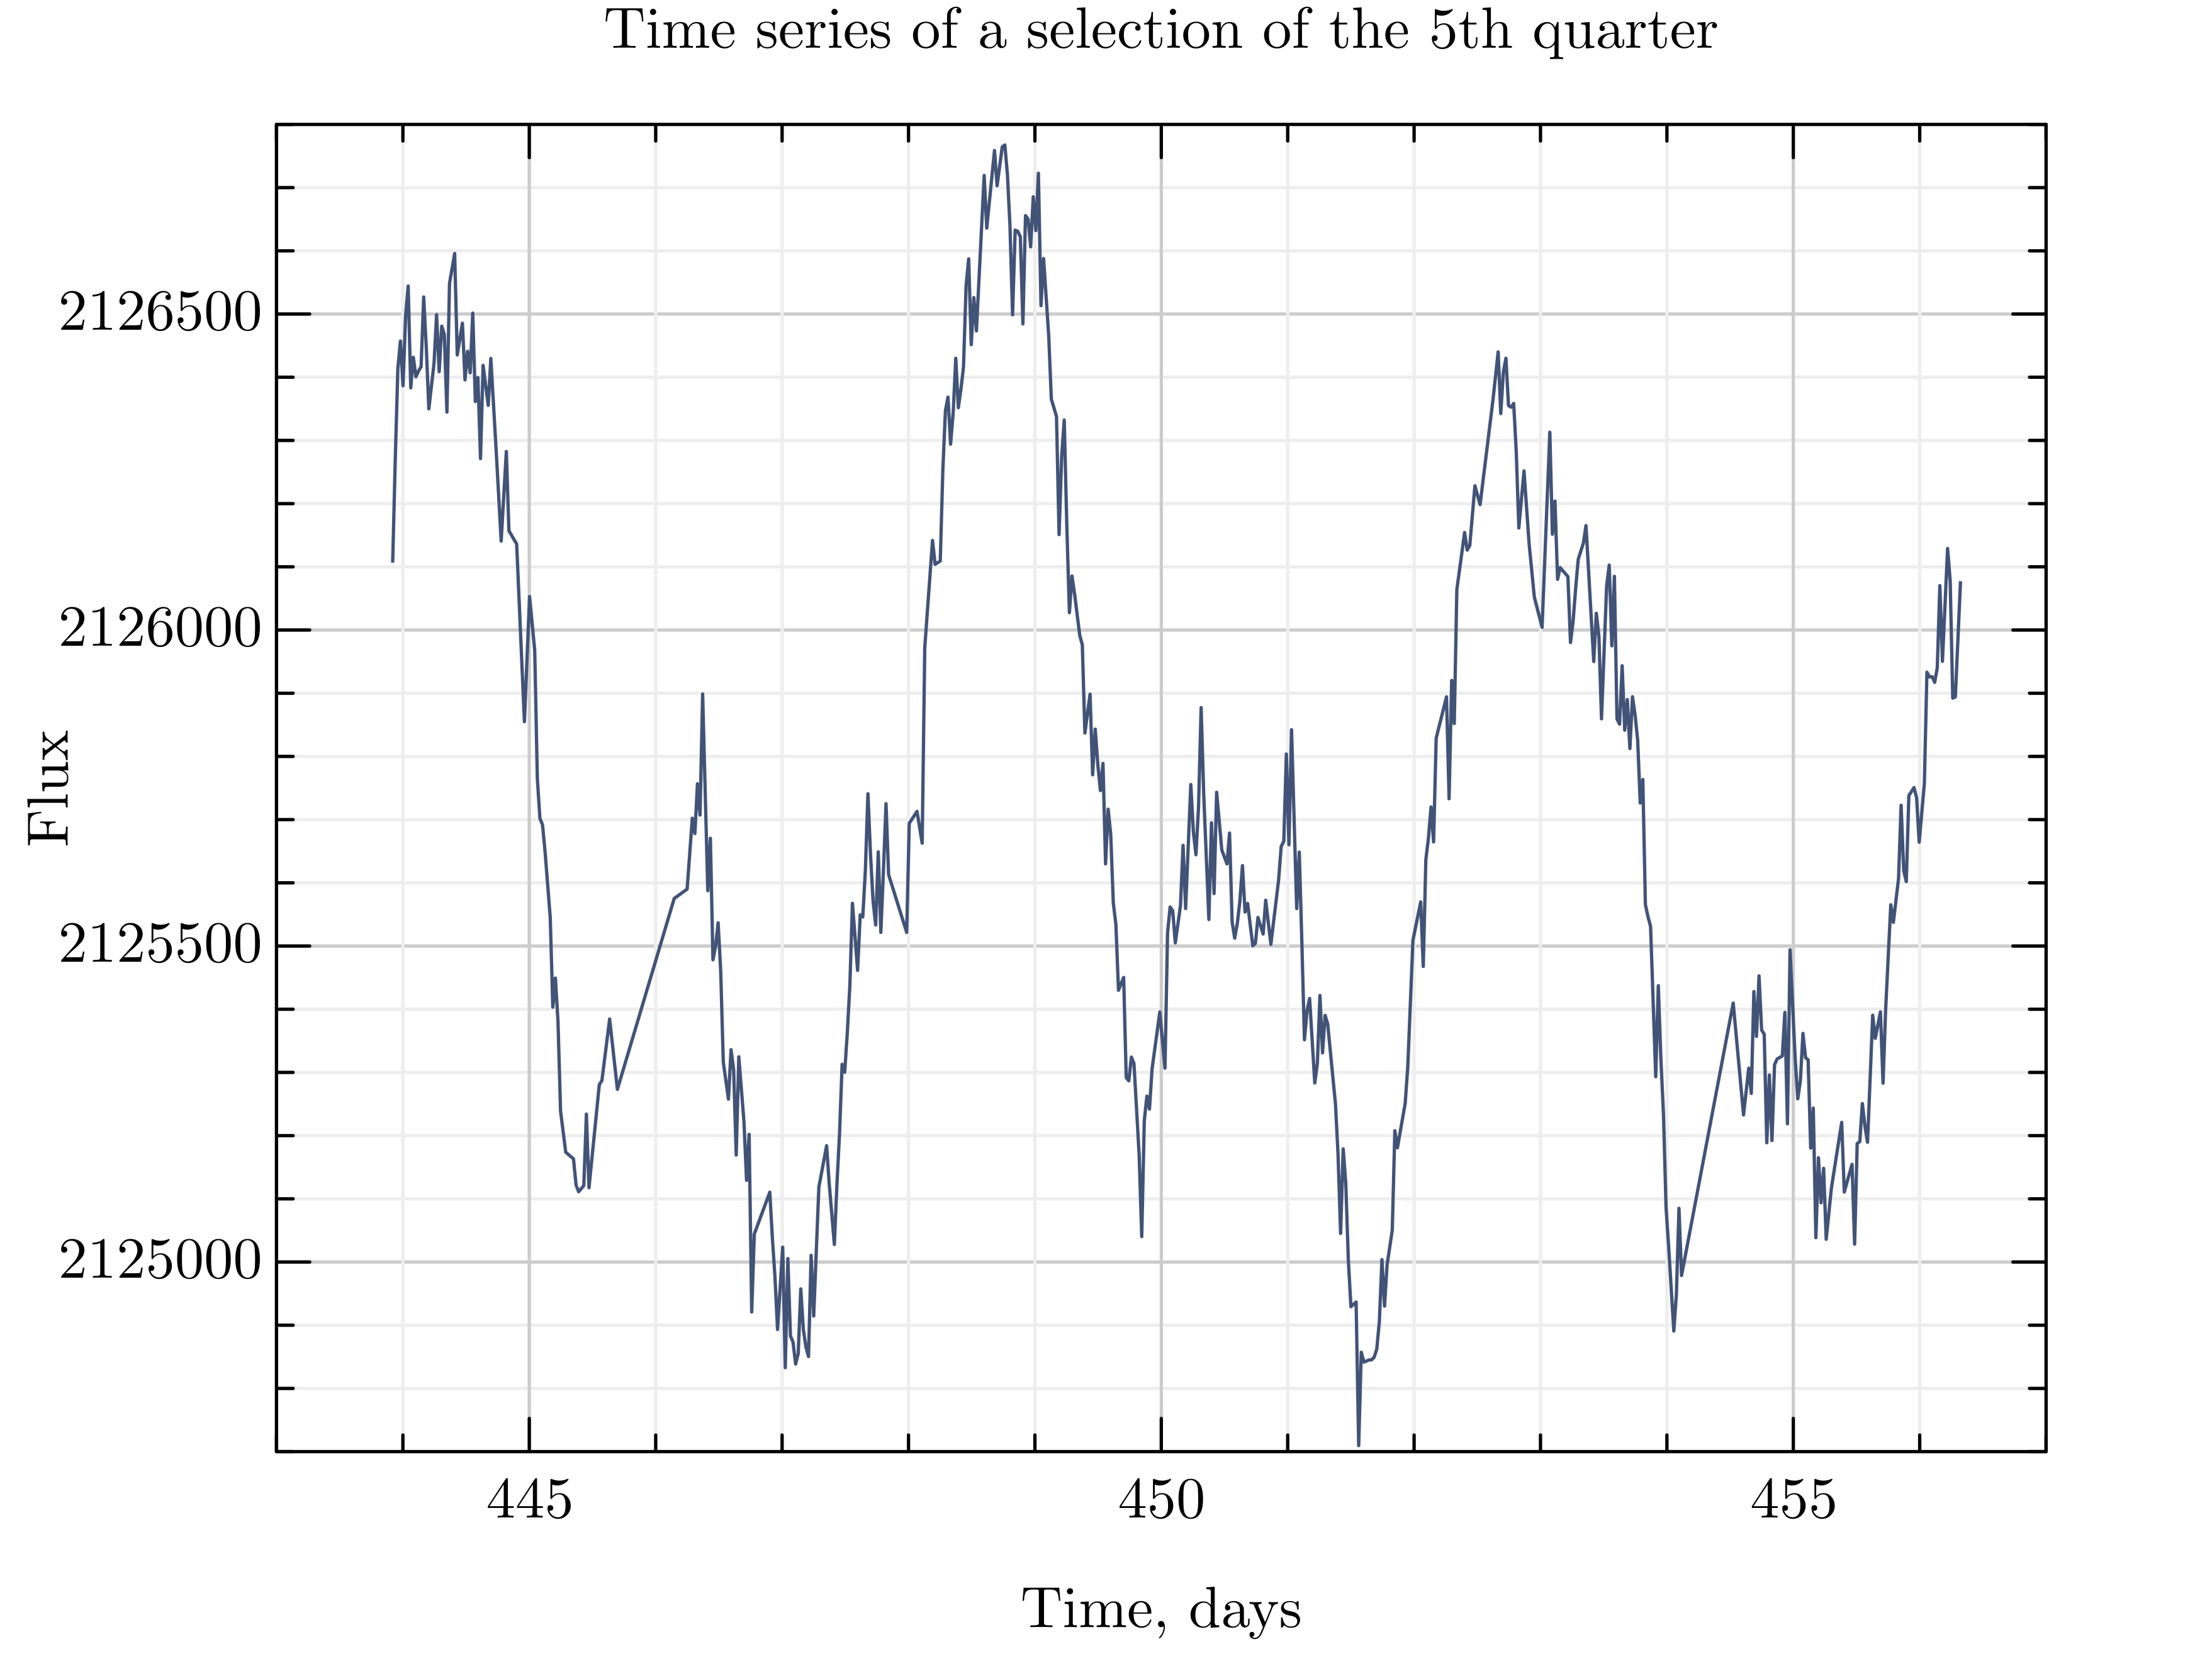

In [9]:
plot(tₛ, fₛ; linecolor)

xlabel("Time, days")
ylabel("Flux")
title("Time series of a selection of the 5th quarter")